In [3]:
%matplotlib notebook
import numpy as np
bathy=np.genfromtxt("FRF_FRF_20150915_1116_NAVD88_LARC_GPS_UTC.csv", delimiter=",",skiprows=1)

In [4]:
bathy.shape

(8223, 14)

In [5]:
bathy.dtype

dtype('float64')

<IPython.core.display.Javascript object>


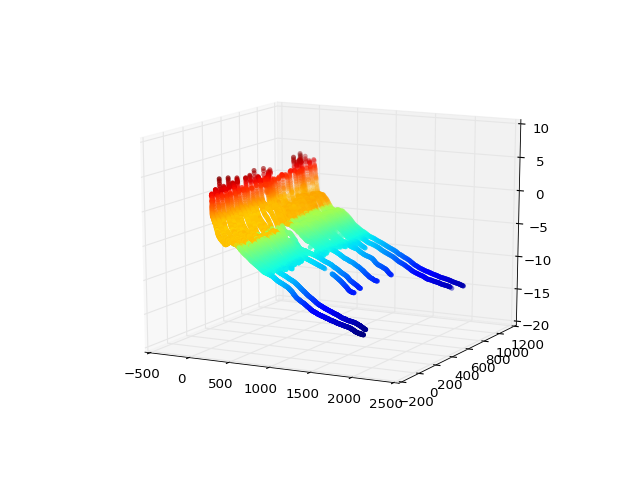

In [6]:
from matplotlib import  pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bathy[:,7], bathy[:,8], bathy[:,9],c=bathy[:,10],linewidths=0)

<IPython.core.display.Javascript object>


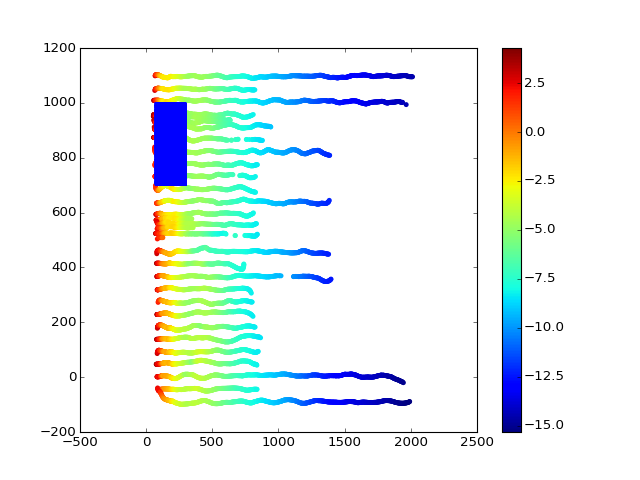

<matplotlib.colorbar.Colorbar instance at 0x7ff31d09ab90>

In [8]:
fig=plt.figure()
plt.scatter(bathy[:,7],bathy[:,8],c=bathy[:,9],linewidths=0)
plt.colorbar()

In [9]:
xmax=bathy[:,7].max()
xmin=bathy[:,7].min()
ymax=bathy[:,8].max()
ymin=bathy[:,8].min()
zmax=bathy[:,9].max()
zmin=bathy[:,9].min()
xmin = 70.0
xmax = 300.0
ymin = 700.0
ymax = 1000.0

In [10]:
print xmax,xmin,ymax,ymin,zmax,zmin

300.0 70.0 1000.0 700.0 4.297 -15.332


In [11]:
from proteus import  Profiling, Comm
comm = Comm.init()
Profiling.verbose=1
Profiling.procID=comm.rank()
Profiling.openLog("frfDomain",level=7)
from proteus.Domain  import InterpolatedBathymetryDomain
bathy_points = np.vstack((bathy[:,7],bathy[:,8],bathy[:,9])).transpose()
print bathy_points.shape
domain = InterpolatedBathymetryDomain(vertices=[[xmin,ymin],[xmin,ymax],[xmax,ymax],[xmax,ymin]],
                                      vertexFlags=[1,1,2,2],
                                      segments=[[0,1],[1,2],[2,3],[3,0]],
                                      segmentFlags=[1,2,3,4],
                                      regions=[(0.5*(xmax+xmin),0.5*(ymax+ymin))],
                                      regionFlags=[1],
                                      name="frfDomain2D",
                                      units='m',
                                      bathy = bathy_points)
domain.writePoly(domain.name)

(8223, 3)


In [12]:
from proteus.MeshTools import  InterpolatedBathymetryMesh
mesh = InterpolatedBathymetryMesh(domain,
                                  triangleOptions="gVApq30Dena%8.8f" % ((1000.0**2)/2.0,),
                                  atol=1.0e-1,
                                  rtol=1.0e-1,
                                  maxLevels=25,
                                  maxNodes=50000,
                                  bathyType="points",
                                  bathyAssignmentScheme="interpolation",
                                  errorNormType="Linfty")

[      59] InterpolatedBathymetryMesh: Calling Triangle to generate 2D coarse mesh for frfDomain2D
TriangleBaseMesh nbase=1 baseFlags= gVApq30Dena500000.00000000 
[      59] InterpolatedBathymetryMesh: Converting to Proteus Mesh
[      59] Partitioning mesh among 1 processors using partitioningType = 0
[      59] Number of Subdomain Elements Owned= 2
[      59] Number of Subdomain Elements = 2
[      59] Number of Subdomain Nodes Owned= 4
[      59] Number of Subdomain Nodes = 4
[      59] Number of Subdomain elementBoundaries Owned= 5
[      59] Number of Subdomain elementBoundaries = 5
[      59] Number of Subdomain Edges Owned= 5
[      59] Number of Subdomain Edges = 5
[      59] Finished partitioning
69000.0
[      59] InterpolatedBathymetryMesh:Allocating data structures for bathymetry interpolation algorithm
[      60] InterpolatedBathymetryMesh: Locating points on initial mesh
[      61] InterpolatedBathymetryMesh:setting mesh bathymetry from data
[      61] InterpolatedBathyme

In [13]:
nodes = mesh.meshList[-1].nodeArray
x,y,z = nodes[:,0],nodes[:,1],nodes[:,2]
print nodes.shape
elements = mesh.meshList[-1].elementNodesArray
print elements.shape,elements.max(),elements.min()
plt.triplot(nodes[:,0],nodes[:,1],elements)
#plt.tricontourf(x=nodes[:,0],y=nodes[:,1],triangles=elements,z=nodes[:,2])

(8385, 3)
(16384, 3) 8384 0


<IPython.core.display.Javascript object>


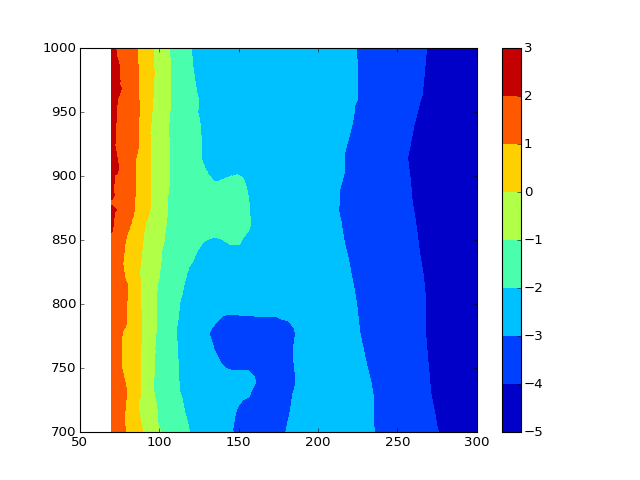

<matplotlib.colorbar.Colorbar instance at 0x7ff30662a4d0>

In [14]:
fit = plt.figure()
plt.tricontourf(nodes[:,0],nodes[:,1],elements,nodes[:,2])
plt.colorbar()

<IPython.core.display.Javascript object>


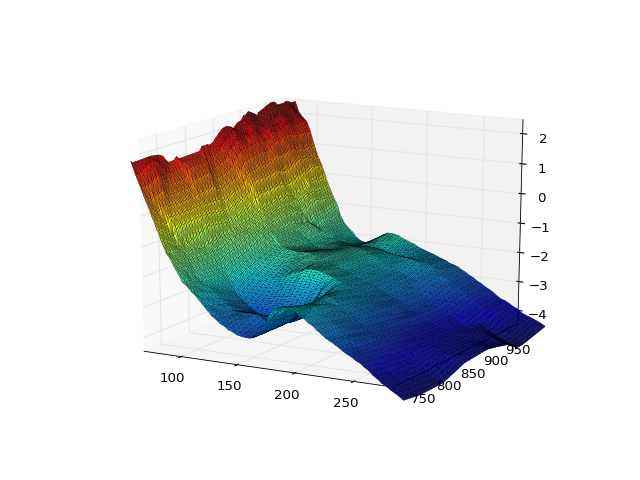

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)

plt.show()

In [16]:
x.shape

(8385,)

In [17]:
print mesh.meshList[-1].nodeMaterialTypes

[1 1 2 ..., 1 1 1]


In [18]:
fineMesh = mesh.meshList[-1]
newNodes = {}
verticalEdges = {}
nN_start = fineMesh.nodeArray.shape[0]
nN = nN_start
for nN_bottom, n,f in zip(range(nN_start), fineMesh.nodeArray, fineMesh.nodeMaterialTypes):
    if f > 0:
        newNodes[nN] = (n[0],n[1],1.5*zmax)
        verticalEdges[nN_bottom] = nN
        nN += 1
newFacets = []
newFacetFlags = []
for t in fineMesh.elementNodesArray:
    newFacets.append([[t[0],t[1],t[2]]])
    newFacetFlags.append(6)
topConnectivity = {}
for edge, edgeF in zip(fineMesh.elementBoundaryNodesArray, fineMesh.elementBoundaryMaterialTypes):
    if edgeF > 0:
        n00 = edge[0]
        n10 = edge[1]
        n11 = verticalEdges[edge[1]]
        n01 = verticalEdges[edge[0]]
        newFacets.append([[n00,
                          n10,
                          n11,
                          n01]])
        newFacetFlags.append(edgeF)
        if topConnectivity.has_key(n11):
            topConnectivity[n11].append(n01)
        else:
            topConnectivity[n11] = [n01]
        if topConnectivity.has_key(n01):
            topConnectivity[n01].append(n11)
        else:
            topConnectivity[n01] = [n11]
topFacet = [topConnectivity[nN_start][0],nN_start,topConnectivity[nN_start][1]]

while len(topFacet) < len(newNodes):
    nN = topFacet[-1]
    if topFacet[-2] == topConnectivity[nN][0]:
        topFacet.append(topConnectivity[nN][1])
    else:
        topFacet.append(topConnectivity[nN][0])
newFacets.append([topFacet])
newFacetFlags.append(5)
newVertices = []
newVertexFlags = []
for n,nF in zip(fineMesh.nodeArray, fineMesh.nodeMaterialTypes):
    newVertices.append([n[0],n[1],n[2]])
    if nF > 0:
        newVertexFlags.append(nF)
    else:
        newVertexFlags.append(6)
for nN in range(len(newNodes.keys())):
    newVertices.append(newNodes[nN+nN_start])
    newVertexFlags.append(5)

<IPython.core.display.Javascript object>


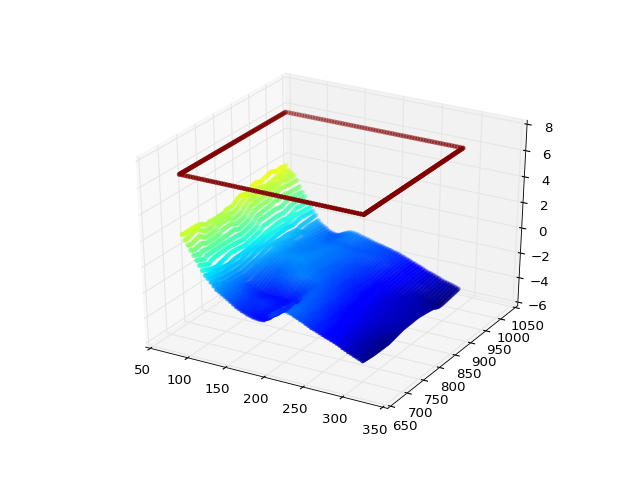

In [19]:
fig = plt.figure()
newNodes = np.vstack((fineMesh.nodeArray,np.array(newNodes.values())))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newNodes[:,0], newNodes[:,1], newNodes[:,2],c = newNodes[:,2],linewidths=0)

In [20]:
from proteus.Domain import PiecewiseLinearComplexDomain
xmin_new = fineMesh.nodeArray[:,0].min()
xmax_new = fineMesh.nodeArray[:,0].max()
ymin_new = fineMesh.nodeArray[:,1].min()
ymax_new = fineMesh.nodeArray[:,1].max()

regions = [[0.5*(xmin+xmax),0.5*(ymin+ymax),zmax-1.0]]
regionFlags = [1.0]
domain3D = PiecewiseLinearComplexDomain(vertices=newVertices,
                                        facets=newFacets,
                                        facetHoles=None,
                                        holes=None,
                                        regions=regions,
                                        vertexFlags=newVertexFlags,
                                        facetFlags=newFacetFlags,
                                        regionFlags=regionFlags,
                                        regionConstraints=None,
                                        name="frfDomain3D",
                                        units="m")

In [21]:
domain3D.writePoly("frfDomain3D")
domain3D.writePLY("frfDomain3D")

In [22]:
!tetgen -KVApq1.35q12feen frfDomain3D.poly

Opening frfDomain3D.poly.
Constructing Delaunay tetrahedralization.
  Sorting vertices by a bsp-tree.
  Number of tree nodes: 146.
  Maximum tree node size: 99.
  Maximum tree depth: 9.
  Incrementally inserting vertices.
Delaunay seconds:  0.259958
Creating surface mesh.
  Unifying segments.
  Merging coplanar facets.
  Marking acute vertices.
  5611 acute vertices.
Recovering boundaries.
  Delaunizing segments.
  7844 protecting points.
  Constraining facets.
  15 subedge flips.
  44 cavities remeshed.
Boundary recovery seconds:  0.582434
Removing exterior tetrahedra.
Hole seconds:  0.067461
Repairing mesh.
Repair seconds:  0.013489
Adding Steiner points to enforce quality.
  Marking sharp segments.
  34622 sharp segments.
  Deciding feature-point sizes.
  Splitting encroached subsegments.
  473 split points.
  Splitting encroached subfaces.
  648 split points.
  Splitting bad tetrahedra.
  28870 refinement points.
  Totally added 29991 points.
Quality seconds:  11.474
Optimizing mes

<IPython.core.display.Javascript object>


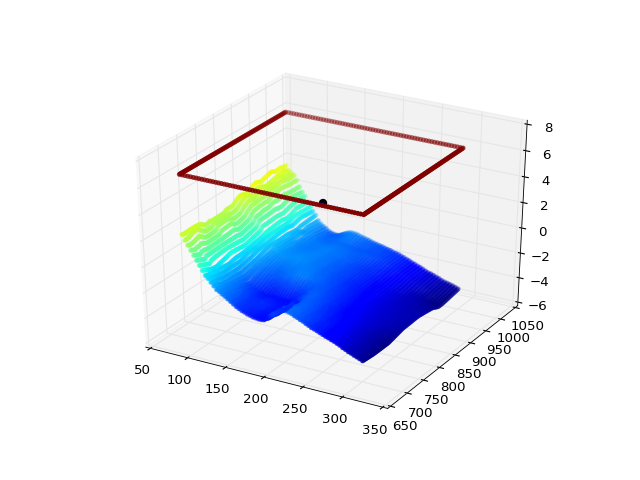

In [23]:
fig = plt.figure()
polyNodes = np.array(domain3D.vertices)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newNodes[:,0], newNodes[:,1], newNodes[:,2],c = newNodes[:,2],linewidths=0)
ax.scatter(regions[0][0],regions[0][1],regions[0][2],linewidths=3)